LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Train dataset size: 60000
Test dataset size: 10000
Epoch 1/5 - Loss: 0.2882, Test Accuracy: 97.15%
Epoch 2/5 - Loss: 0.0804, Test Accuracy: 98.11%
Epoch 3/5 - Loss: 0.0574, Test Accuracy: 98.64%
Epoch 4/5 - Loss: 0.0461, Test Accuracy: 98.48%
Epoch 5/5 - Loss: 0.0383, Test Accuracy: 98.68%


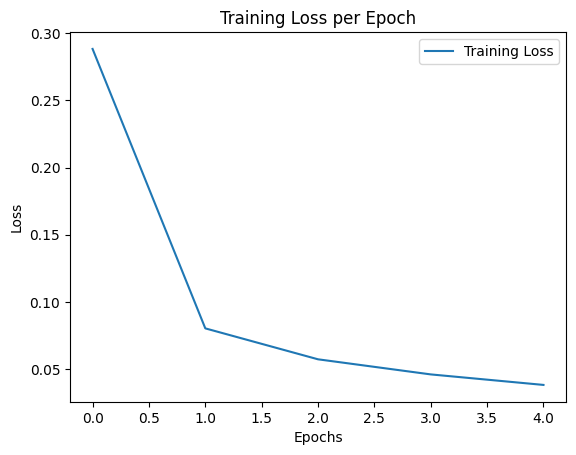

Text(0, 0.5, 'Accuracy (%)')

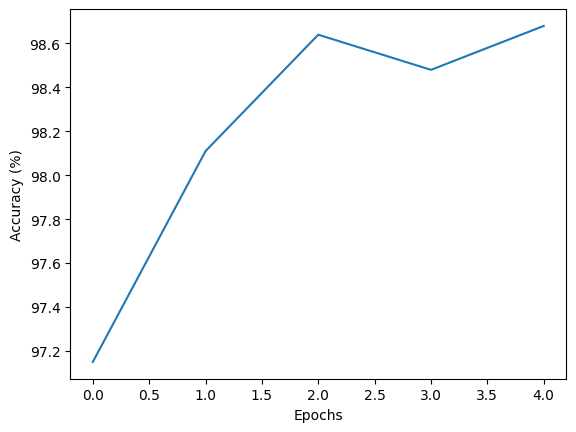

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt


class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        #cnvolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)

        #fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  #output layer for 10 classes

    def forward(self, x):
        #forward pass through the layers
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))

        #flatten the output from the convolutional layers
        x = x.view(-1, 16 * 6 * 6)

        #fully connected layers with reulu activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        #final output (no activation since CrossEntropyLoss will handle it)
        x = self.fc3(x)
        return x

#instantiate model
model = LeNet5()
print(model)

#define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  #resize to 32x32
    transforms.ToTensor(),  #convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  #normalize dataset
])

#load MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#data loaders for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

#check the dataset
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

#loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

#training loop
n_epochs = 5
train_losses = []
test_accuracies = []

#training and evaluation function
def train_and_evaluate(model, train_loader, test_loader, n_epochs):
    for epoch in range(n_epochs):
        model.train()  #set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            #zero the parameter gradients
            optimizer.zero_grad()

            #forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            #backward pass and optimization
            loss.backward()
            optimizer.step()

            #accumulate the loss
            running_loss += loss.item()

        #average training loss for the epoch
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        #evaluate the model on the test set
        test_accuracy = evaluate(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{n_epochs} - Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

#evaluation function
def evaluate(model, test_loader):
    model.eval()  #set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  #no need to compute gradients during evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  #get the class with the highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

#run the training and evaluation
train_and_evaluate(model, train_loader, test_loader, n_epochs)


#loss plot
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

#acuracy plot
plt.figure()
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')